# Preprocessing

In [1]:
#for sentiment analysis
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
#NLTK package
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn import metrics

%matplotlib inline

In [2]:
#google colab code
#from google.colab import drive
#drive.mount('/content/drive')


In [3]:
#df = pd.read_json("/content/drive/MyDrive/All_Beauty.json",lines = True) #google colab code
df = pd.read_json("All_Beauty.json",lines= True)

In [4]:
df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,371345.000000,3.713450e+05
mean,4.112093,1.440742e+09
std,1.362099,6.962743e+07
min,1.000000,9.474624e+08
25%,4.000000,1.416096e+09
50%,5.000000,1.456963e+09
75%,5.000000,1.485562e+09
max,5.000000,1.538438e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         371345 non-null  int64 
 1   verified        371345 non-null  bool  
 2   reviewTime      371345 non-null  object
 3   reviewerID      371345 non-null  object
 4   asin            371345 non-null  object
 5   reviewerName    371307 non-null  object
 6   reviewText      370946 non-null  object
 7   summary         371139 non-null  object
 8   unixReviewTime  371345 non-null  int64 
 9   vote            51899 non-null   object
 10  style           125958 non-null  object
 11  image           8391 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 31.5+ MB


In [7]:
#drop the last two columns as not useful for the analysis
df.drop(df.columns[-3:],axis =1,inplace = True )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         371345 non-null  int64 
 1   verified        371345 non-null  bool  
 2   reviewTime      371345 non-null  object
 3   reviewerID      371345 non-null  object
 4   asin            371345 non-null  object
 5   reviewerName    371307 non-null  object
 6   reviewText      370946 non-null  object
 7   summary         371139 non-null  object
 8   unixReviewTime  371345 non-null  int64 
dtypes: bool(1), int64(2), object(6)
memory usage: 23.0+ MB


In [9]:
df.shape

(371345, 9)

<AxesSubplot:>

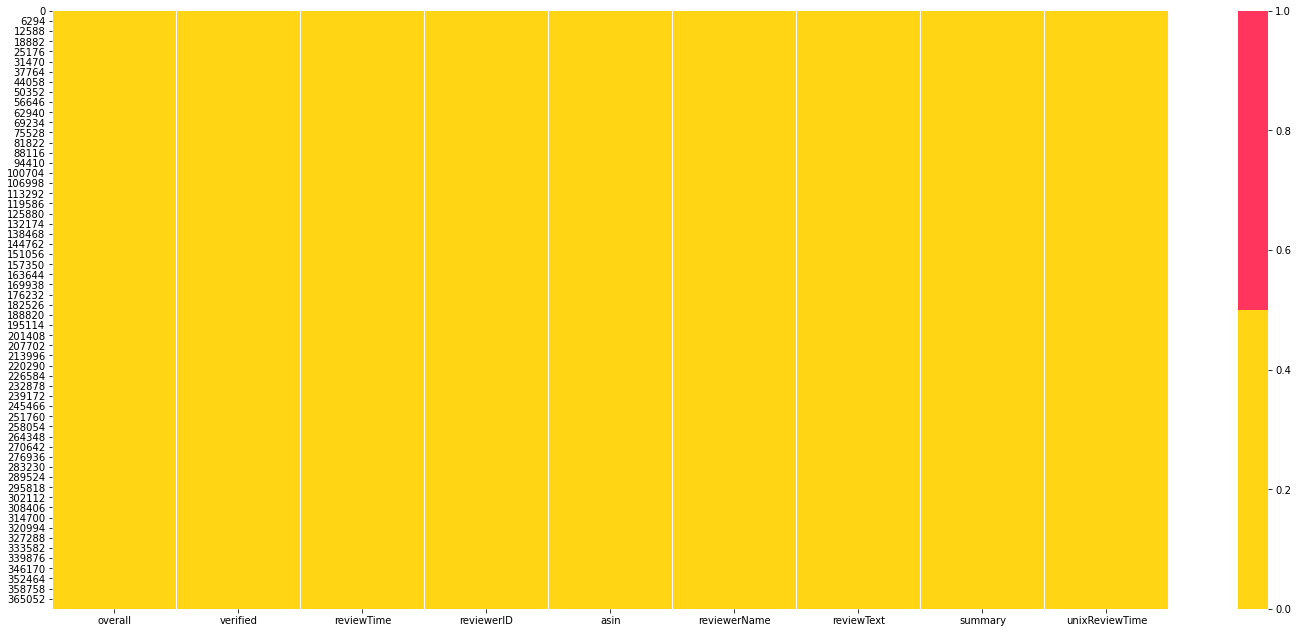

In [10]:
#Visualize the data for empty values
plt.figure(figsize = (25,11))
sns.heatmap(df.isna().values, cmap = ['#ffd514','#ff355d'],xticklabels = df.columns)

In [11]:
#drop duplicates row
df.drop_duplicates()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200
...,...,...,...,...,...,...,...,...,...
371340,1,True,"07 20, 2017",A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,1500508800
371341,5,True,"03 16, 2017",A3FSOR5IJOFIBE,B01HJEGTYK,TYW,I was skeptical about buying this. Worried it...,Awesome,1489622400
371342,5,True,"03 1, 2017",A1B5DK6CTP2P24,B01HJEGTYK,Norma Jennings,Makes me look good fast.,Five Stars,1488326400
371343,2,True,"02 21, 2017",A23OUYS5IRMJS9,B01HJEGTYK,Lee,Way lighter than photo\nNot mix blend of color...,Ok but color way off and volume as well,1487635200


In [12]:
df['reviewText'].head()

0                                                great
1    My  husband wanted to reading about the Negro ...
2    This book was very informative, covering all a...
3    I am already a baseball fan and knew a bit abo...
4    This was a good story of the Black leagues. I ...
Name: reviewText, dtype: object

In [13]:
reviews = df['reviewText']

In [14]:
reviews.count() # check the review counts

370946

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stop_words = stopwords.words('english')

In [17]:
#text preprocessing
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def preprocessing(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

In [18]:
df['review_CLEAN'] = df['reviewText'].apply(lambda x: preprocessing(str(x)))

In [19]:
df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,review_CLEAN
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,great


In [20]:
#show wordcloud in preprocessed data
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(df.review_CLEAN))

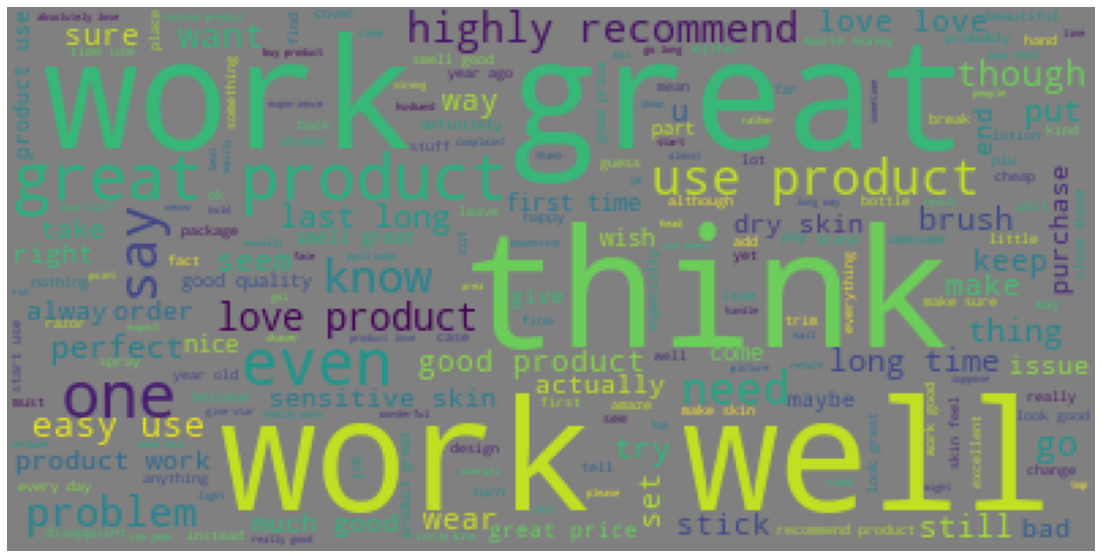

In [21]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

In [22]:
#put the score range as > 3 as 1 (positive) and the rest as 0 (negative)
df['Label'] = [1 if x > 3 else 0 for x in df.overall]

In [23]:
df['Label'].value_counts()

1    282236
0     89109
Name: Label, dtype: int64

# EDA for Sentiment Analysis

In [24]:
df["categories"] = df["overall"]
df["categories"].replace({5.0: "positive",4.0:"positive",3.0:"negative",2.0:"negative",1.0:"negative"}, inplace=True)
df["categories"].unique()

array(['negative', 'positive'], dtype=object)

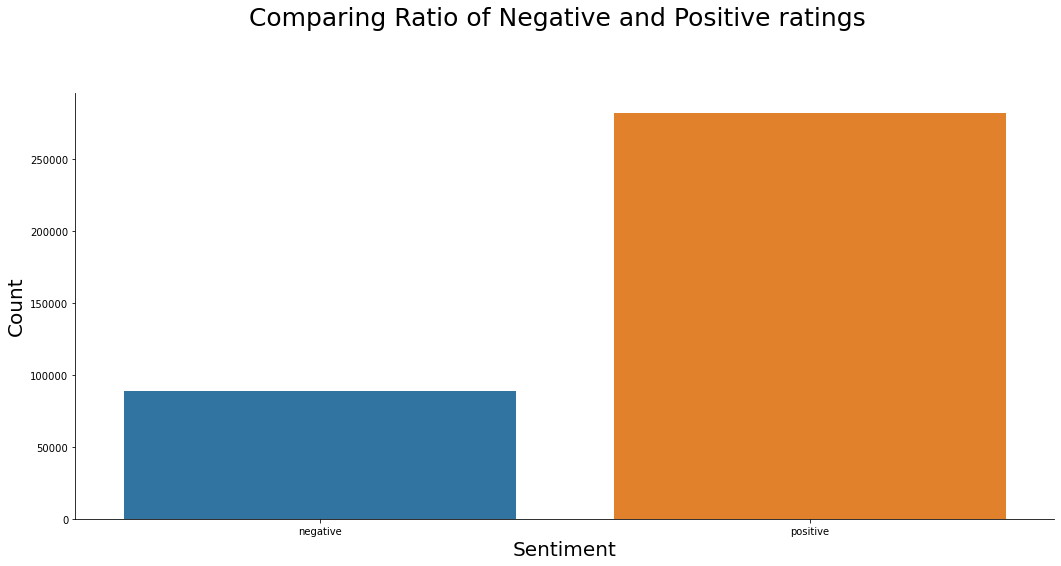

In [25]:
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = df["categories"], data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [26]:
# Percentage of negative, positive words in train and test data
def ratio_count(data, category):
    return (len(data[data["categories"] == category])/len(data)) * 100

In [27]:
print(f"Percentage of negative words in Train dataset --> {ratio_count(df, 'negative')} %")
print(f"Percentage of positive words in Train dataset --> {ratio_count(df, 'positive')} %")

Percentage of negative words in Train dataset --> 23.996283779234943 %
Percentage of positive words in Train dataset --> 76.00371622076506 %


## Words and word clouds


In [28]:
from wordcloud import WordCloud, STOPWORDS

# Most repeated words in reviews
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "black",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()

In [29]:
# seperating all records into a different variable to generate wordcloud based on category
negative = df[df["categories"] == "negative"]["review_CLEAN"]
positive = df[df["categories"] == "positive"]["review_CLEAN"]

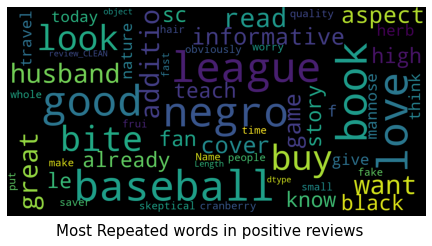

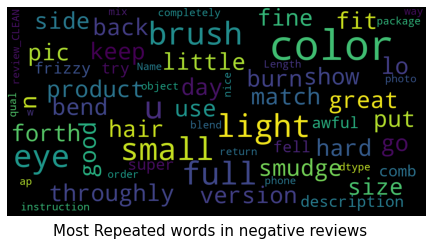

In [30]:
# Generating wordcloud based on category
word_cloud(positive, "Most Repeated words in positive reviews")
word_cloud(negative, "Most Repeated words in negative reviews")

In [31]:
# To get top bigrams words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]# apply function above 

C:\Users\65838\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\65838\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


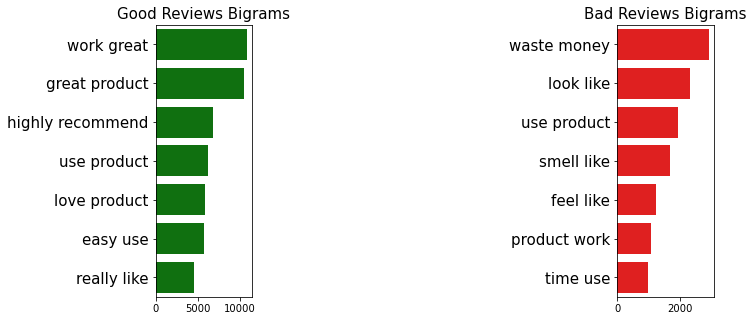

In [32]:
# To plot bigram graphs
def n_gram_plot(data,title,color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('{} Reviews Bigrams'.format(title),fontsize=15)
    plt.yticks(rotation=0,fontsize=15)

common_words_good = get_top_n_bigram(positive, 7)
common_words_bad= get_top_n_bigram(negative, 7)

# bigram plot using function above
plt.figure(figsize=(10,5))
# good reviews bigrams
plt.subplot(151)
n_gram_plot(common_words_good,'Good','green')
#bad reviews bigrams
plt.subplot(155)
n_gram_plot(common_words_bad,'Bad','red')
plt.show()

## Sentiment Distributions using TextBlob

In [33]:
from textblob import TextBlob

In [34]:
# calculating sentiment polarity using textblob
df['sentiment'] = df['review_CLEAN'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,review_CLEAN,Label,categories,sentiment
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,great,0,negative,0.800000
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,husband want read negro baseball great additio...,1,positive,0.800000
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,book informative cover aspect game,1,positive,-0.400000
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,already baseball fan know bite negro league le...,1,positive,0.000000
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,good story black league buy book teach high sc...,1,positive,0.228333


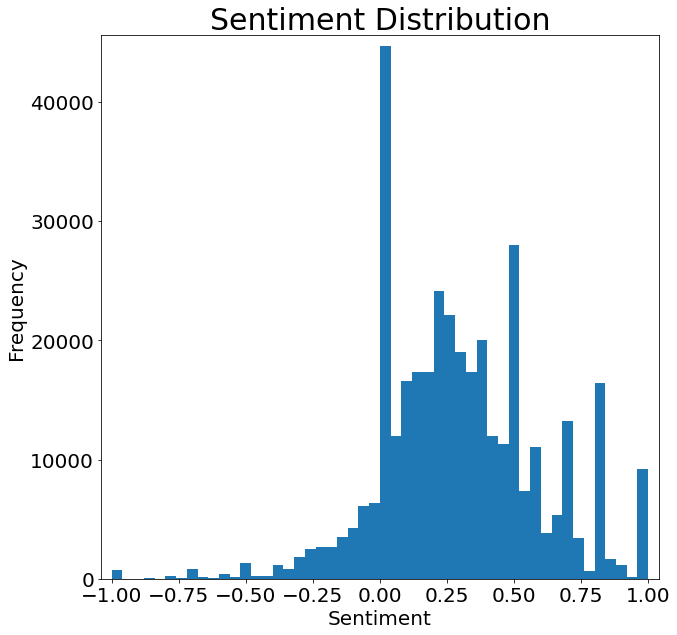

In [35]:
#Barchart using to visualize the sentiment distribution generated above
plt.figure(figsize=(10,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=30)
plt.show()

<ipython-input-36-ebf7b8334cca>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

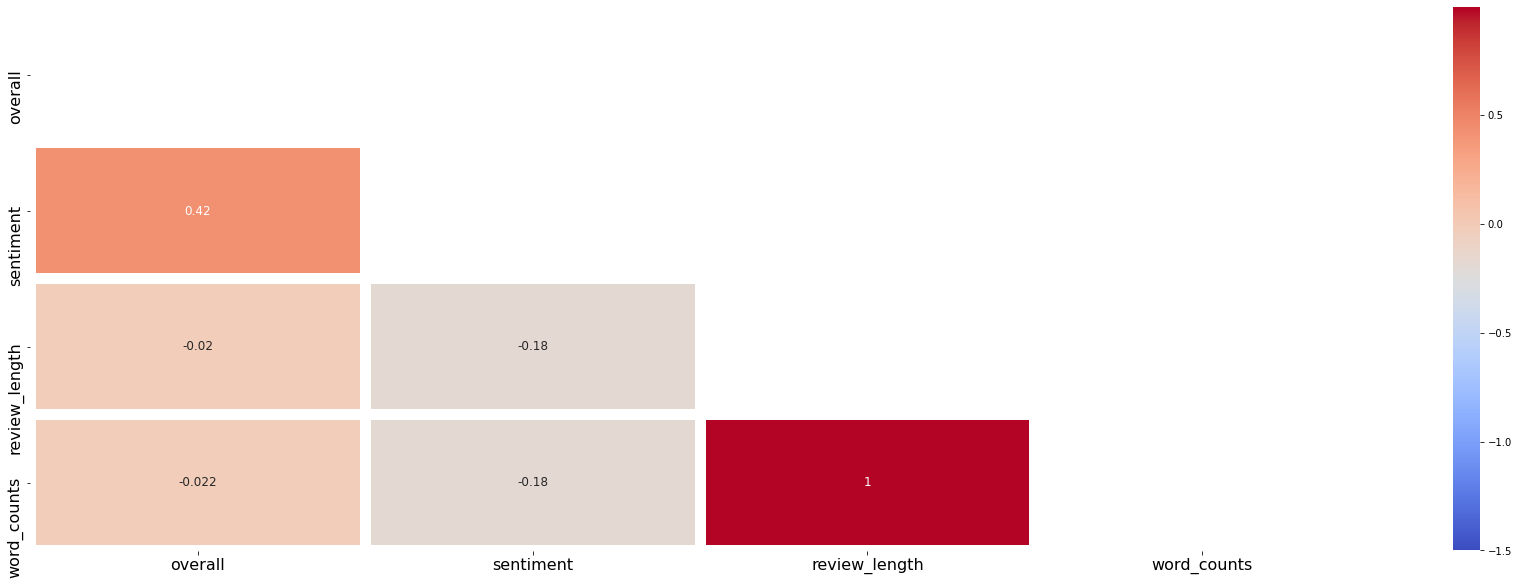

In [36]:
# Heatmap from overall rating, review length, sentiment and word count

# calculating word count and review length
df['word_counts'] = df["reviewText"].apply(lambda x: len(str(x).split(" ")))
df['review_length'] =df["reviewText"].apply(lambda x: len(str(x)))

# visualising the heatmap
correlation = df[['overall','sentiment', 'review_length', 'word_counts']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 12}, linewidths=10, vmin=-1.5, mask=mask)

In [37]:
pd.set_option('display.max_colwidth', None)
df[df["word_counts"] >= 5][["reviewText", "sentiment"]][10:15]

,reviewText,sentiment
11,great eye liner. good seller,0.750000
12,"purchased for vending resale at bellydance weekend workshop. Nice quality, love the compact packaging, ingredient details are a bit sketchy but i haven't gone blind yet",0.200000
13,I love it and it arrived on time,0.500000
15,It goes on very easily and makes my eyes look Bold and Beautiful,0.538889
17,"LOVE, LOVE, LOVE!! The movie was breathtaking and this book really shows you the behind-the-scenes work that was needed to make the gorgeous film. A must buy for any lover of the film or art in general.",0.381250


# Sentiment Classifier Model Training

In [38]:
df.Label

0         0
1         1
2         1
3         1
4         1
         ..
371340    0
371341    1
371342    1
371343    0
371344    0
Name: Label, Length: 371345, dtype: int64

In [39]:
beauty_cat = df[["Label","review_CLEAN"]]
beauty_cat.groupby('Label').describe()

review_CLEAN                    
             count  unique   top  freq
Label                                 
0            89109   79760  work   552
1           282236  224038  love  4062

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df.review_CLEAN, df.Label, random_state=0)

In [41]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (278508,)
y_train shape: (278508,)

x_test shape: (92837,)
y_test shape: (92837,)



## Multinomial Nayes Bayes with CountVectorizer


In [42]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<278508x13645 sparse matrix of type '<class 'numpy.int64'>'
	with 4502426 stored elements in Compressed Sparse Row format>


In [43]:
features = vectorizer.get_feature_names_out()
print("Number of features: {}".format(len(features)))

Number of features: 13645


In [44]:
print("Show some feature names : \n", vectorizer.get_feature_names_out()[::1000])

Show some feature names : 
 ['aa' 'bcs' 'chiropractor' 'definatly' 'esteem' 'glisten' 'indifferent'
 'lord' 'nob' 'platform' 'replicate' 'slider' 'ten' 'vey']


In [45]:
scores = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)

In [46]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.846


In [47]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [48]:
X_test = vectorizer.transform(x_test)

In [49]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [50]:
# Evaluate the model on validaton set
predictions = mnb.predict(X_test)
modelEvaluation(predictions)


Accuracy on validation set: 0.8483

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.59      0.65     22179
           1       0.88      0.93      0.90     70658

    accuracy                           0.85     92837
   macro avg       0.80      0.76      0.78     92837
weighted avg       0.84      0.85      0.84     92837


Confusion Matrix : 
 [[13185  8994]
 [ 5094 65564]]


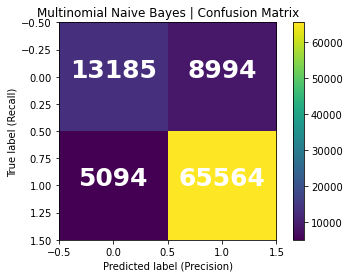

In [51]:
mnb_cfm = confusion_matrix(y_test, predictions)
plt.imshow(mnb_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white",fontsize = 25, fontweight = 'bold')

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial Naive Bayes | Confusion Matrix')
plt.colorbar();

## Logistic Regression with TF IDF Vectorizer

In [52]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(x_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 13645 

Show some feature names : 
 ['aa' 'bcs' 'chiropractor' 'definatly' 'esteem' 'glisten' 'indifferent'
 'lord' 'nob' 'platform' 'replicate' 'slider' 'ten' 'vey']


C:\Users\65838\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['disappoint' 'return' 'waste' 'poor' 'horrible' 'terrible' 'useless'
 'unfortunately' 'break' 'disappointment']

Top 10 features with the largest coefficients : 
['love' 'great' 'perfect' 'amaze' 'excellent' 'perfectly' 'awesome'
 'wonderful' 'highly' 'best']


In [54]:
# Evaluating on the validaton set
predictions = lr.predict(tfidf.transform(x_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8754

Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.64      0.71     22179
           1       0.89      0.95      0.92     70658

    accuracy                           0.88     92837
   macro avg       0.85      0.80      0.82     92837
weighted avg       0.87      0.88      0.87     92837


Confusion Matrix : 
 [[14242  7937]
 [ 3632 67026]]


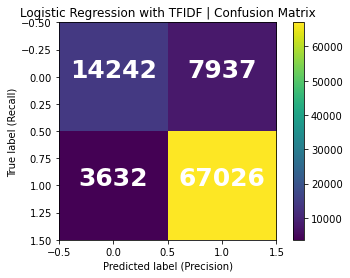

In [55]:
cfm = confusion_matrix(y_test, predictions)
plt.imshow(cfm, interpolation='nearest')

for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
    plt.text(j, i, cfm[i, j],
             horizontalalignment="center",
             color="white",fontsize = 25, fontweight = 'bold')

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Regression with TFIDF | Confusion Matrix')
plt.colorbar();

# Topic Modelling 

 ## Topic Modelling with IDF feature vectors

In [56]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
review_text = df["review_CLEAN"]


In [57]:
# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

In [58]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 56208


C:\Users\65838\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:
LDA = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [60]:
num_top_words = 15

def top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

In [61]:
LDA_tf = LDA.fit(tf)

In [62]:
LDA_ = LDA_tf.transform(tf)
Counter([np.argmax(i) for i in LDA_])


Counter({3: 47444,
         1: 25683,
         6: 26257,
         2: 111223,
         9: 13665,
         0: 74138,
         4: 23943,
         7: 16007,
         5: 15335,
         8: 17650})

In [63]:
top_words(LDA_tf, tfidf_feature_names, num_top_words)


Topic #0:
like use good get small clean well little would make easy one work size seem

Topic #1:
love color light buy gift dark daughter money last perfect full waste wear absolutely nice

Topic #2:
use product get try time like day go work order really feel review dry apply

Topic #3:
great product good work price recommend well really buy quality happy would purchase look wig

Topic #4:
one use buy year find month many old purchase amazon get disappoint store new break

Topic #5:
perfect package set fast quality receive come arrive ship excellent high thank exactly ok box

Topic #6:
skin use face nail make amaze stuff soap cream smooth recommend soft body also wash

Topic #7:
smell scent oil bottle like deodorant last fragrance shampoo teeth strong lipstick red favorite pink

Topic #8:
expect shave last head razor time best long blade travel always close need ever shaver

Topic #9:
hair brush look super nice picture soft dry polish beautiful thick make everything style coat




## Topic Modelling with TFIDF feature vectors

In [64]:
LDA_tfidf = LDA.fit(tfidf)

In [65]:
LDA_W = LDA_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in LDA_W])

Counter({3: 17071,
         1: 292602,
         0: 2378,
         5: 23359,
         8: 4949,
         6: 16730,
         2: 3268,
         7: 2396,
         4: 6181,
         9: 2411})

In [66]:
top_words(LDA_tfidf, tfidf_feature_names, num_top_words)


Topic #0:
shampoo serum conditioner liner hydrate costume granddaughter worth primer tweezer excelent vanilla penny beach braid

Topic #1:
use product love hair great like get work good skin one make color look buy

Topic #2:
awesome like sticky terrible tangle fill tea hat sorry total pressure extension claim image install

Topic #3:
great good work product price quality well delivery wonderful lash value flavor deal quick reasonable

Topic #4:
smell beautiful scent color deodorant lotion favorite fragrance lovely perfume blend picture earring nice like

Topic #5:
nice perfect cute ok exactly describe look really arrive item fit work pretty great wife

Topic #6:
love excellent thank gift product fast stuff amaze buy daughter ship happy absolutely purchase christmas

Topic #7:
teeth nan floss adorable gum brush relax dentist mouth pillow fantastic waterpik moist dental tooth

Topic #8:
expect wig small best clip service kid ever soap purse big bracelet fun variety expectation

Topic #9